# Notæ 5

# Automatización de pruebas computacionales

En los notebooks anteriores vimos los fundamentos para poder generar grafos con el paquete NetworkX, modelar problemas de optimización en grafos con PLE, escribir estos modelos en Python, resolverlos con CPLEX y visualizar su salida. Sin embargo, todo este proceso fue bastante "manual", en el sentido de que tuvimos que "tocar" algo del código cada vez que cambiamos el grafo de entrada.

El objetivo de este notebook es aprender buenas prácticas para automatizar este proceso. Partiremos de un dataset, es decir, un directorio que contenga un archivo por cada instancia de interés, resolveremos el problema en estudio sobre cada una de ellas y escribiremos las salidas de CPLEX en un archivo. 

De esta forma, podemos dejar corriendo pruebas durante horas o días, y al finalizar, podemos revisar los archivos generados y analizar las salidas producidas. Más adelante veremos algunas herramientas de Python para recolectar y analizar estadísticamente estos datos.

En primer lugar, vamos a necesitar todos los generadores de grafos que definimos en el notebook 4. Si bien podríamos copiar todas las definiciones acá, vamos a seguir un enfoque diferente para que el notebook no quede demasiado largo. Ya nos tomamos el trabajo de pasar todas estas definiciones a un archivo <code>generadores.py</code> que lo pueden descargar del siguiente  <a href="https://github.com/maurolucci/taller-cplex/blob/main/generadores.py">link</a>. <b>Guarden este archivo en el mismo directorio donde está este notebook</b> (si siguieron las intrucciones, debería ser en el directorio Taller/). 

Una vez hecho esto, ya podemos hacer la importación del módulo <code>generadores</code>. En en este caso, optamos por ponerle un nombre abreviado <code>gen</code> (como hicimos con networkx y nx).

In [1]:
import generadores as gen

También vamos a necesitar importar algunos módulos de CPLEX, en particular necesitaremos la clase <code>Model</code> del módulo <code>model</code> (como hicimos anteriormente) y agregamos la clase <code>SolveSolution</code> del módulo <code>solution</code> (la necesitaremos para manipular adecuadamente las soluciones).

In [2]:
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution

Y el módulo <code>networkx</code>.

In [3]:
import networkx as nx

## Caso de estudio

<b>Definición.</b> Dado un grafo $G=(V,E)$ y dos vectores $k,u \in \mathbb{N}_0^V$, una función de $(k,u)$-dominación de $G$ es una función $f: V \to \mathbb{N}_0$ tal que, para todo $v \in V$, $f(v) \leq u_v$ y $f(N[v]) \doteq \sum_{w \in N[v]}f(w) \geq k_v$. 

Vamos a trabajar con el siguente problema.

<b>Problema de Dominación Generalizado (PDG)</b>.<br>
<b>Entrada.</b> Un grafo $G=(V,E)$ y dos vectores $k,u \in \mathbb{N}_0^V$.<br>
<b>Objetivo.</b> Encontrar una función $f$ de $(k,u)$-dominación de $G$ con mínimo $f(V) \doteq \sum_{v \in V}f(v)$.

Este problema generaliza a muchos problemas de dominación. En particular generaliza a la dominación clásica cuando $u = k = \boldsymbol{1}$.

Una formulación de PLE intuitiva para este problema es la siguiente.

\begin{align*}
\min & \sum_{v \in V} f_v & \\
s.a.\ & \sum_{w \in N[v]} f_w \geq k_v & \forall\ v \in V.\tag{1}\\
& f_v \leq u_v & \forall\ v \in V.\tag{2}\\ 
& f_v \in \mathbb{N}_0 & \forall\ v \in V.\\
\end{align*}

<b>AGREGAR REF A PAPER DE GRACIELA</b>

Y en Python podemos escribir una función que construya y resuelva este modelo de la siguiente forma. No nos vamos a detener demasiado porque ya hemos mencionado en notebooks anteriores como hacerlo. Solamente vamos a aclarar los siguientes puntos. 
* La función toma un argumento por cada entrada de PDG. En particular, los vectores $k$ y $u$ los representamos con listas de Python. 
* Agregamos un argumento <code>archivo</code> a la función (con un valor <code>None</code> por defecto). Más adelante veremos por qué. Por lo pronto, adelantamos que lo usaremos para que CPLEX escriba el log en ese archivo. En caso de mantener el valor por defecto, no se escribe el log en ningún lado.
* Las variables enteras las agregamos con el método <code>integer_var</code> de la clase <code>Model</code>, que toma como argumento una cota inferior para la variable, una cota superior y el nombre de la variable. Estas cotas hacen que las restricciones (2) puedan ser deducidas por CPLEX y no necesiten ser agregadas al modelo.
* Retornamos directamente el modelo y la solución de CPLEX. Un poco más adelante aprenderemos a manipularlos adecuadamente.

In [4]:
def resolver_PDG(G, k, u, archivo=None):
    """Construye y resuelve el modelo de PLE para el PDG."""
    
    # Inicializamos el modelo 
    modelo = Model(name='dom-gen') 
    
    # Variables
    F = [modelo.integer_var(0, u[v], 'f_' + str(v)) for v in G]
    
    # Funcion objetivo
    modelo.minimize(modelo.sum(F[v] for v in G))
    
    # Restricciones (1)
    # Recordar que G.neighbors(v) es la vecindad abierta de v
    for v in G:
        modelo.add_constraint(F[v] + modelo.sum(F[w] for w in G.neighbors(v)) >= k[v])

    # Resolvemos el modelo
    sol = modelo.solve(log_output=archivo)
 
    # Retornamos la solucion
    return modelo, sol

## Dataset

En esta sección nos ocuparemos de armar nuestro dataset para el PDG. La pregunta que tenemos que responder es: ¿cuáles instancias nos interesa resolver? Por supuesto que la respuesta depende de lo que estemos estudiando. 

Por ejemplo, dado que el PDG es difícil en bipartitos y split, nos podría interesar estudiar la performance del modelo sobre estas clases. Por este motivo, vamos a definir dos nuevos generadores de grafos aleatorios para estas clases.

Por supuesto, también tenemos a disposición todos los generadores de grafos de NetworkX y los que definimos en el notebook anterior. A modo de completitud, también incluiremos en nuestro dataset algunos grafos generados con esas funciones.

Antes de seguir importamos el módulo <code>random</code>.

In [5]:
import random

### Grafos bipartitos aleatorios

<b>Definición.</b> Un grafo $G=(V,E)$ es bipartito si $V$ se puede particionar en dos conjuntos $A$ y $B$, es decir, $V = A \cup B$ y $A \cap B = \emptyset$, tales que toda arista conecta un vértice de un conjunto con un vértice del otro, es decir, para todos $a_1,a_2 \in A$ y $b_1,b_2 \in B$, se tiene $a_1a_2, b_1b_2 \not\in E$.

La generación de un grafo bipartito aleatorio $G=(A \cup B, E)$ se puede realizar por medio de los siguientes parámetros:
* Un número natural $nA$ que representa el cardinal de $A$ (primer conjunto de la bipartición).
* Un número natural $nB$ que representa el cardinal de $B$ (segundo conjunto de la bipartición).
* Un número real $p \in [0,1]$ que representa la probabilidad de que un vértice de $A$ y uno de $B$ sean adyacentes.

La idea de la generación es la siguiente. Recorremos cada par de vértices $(a,b)$ con $a \in A$ y $b \in B$ y decidimos si agregamos una arista entre $a$ y $b$ de forma aleatoria. Para ello, generamos un número flotante aleatorio en $[0,1]$ con una distribución uniforme mediante la función <code>random</code> del módulo <code>random</code>. Si el número aleatorio generado es menor a $p$ entonces agregamos la arista. El único cuidado que tenemos que tener es no pisar el nombre de los vértices de $A$ con los de $B$. Por este motivo, etiquetamos a los vértices de $A$ como $\{0,1,\ldots,nA-1\}$ y a los de $B$ como $\{nA,nA+1,\ldots,nB-1\}$.

In [6]:
def generar_bipartito_aleatorio(nA,nB,p):
    G = nx.Graph()
    # Aristas entre A y B
    for a in range(nA):
        for b in range(nB):
            if random.random() < p: # Agregamos arista?
                G.add_edge(a, nA+b)
    return G

Probamos nuestra función y graficamos el grafo resultante. Aprovechamos que NetworkX nos provee la función <code>bipartite_layout(G, A)</code> que nos computa un lindo layout para los vértices. 

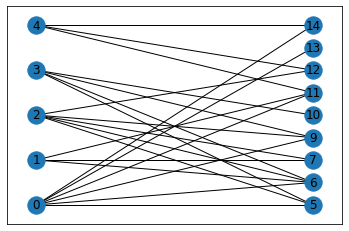

In [7]:
nA = 5
nB = 10
p = 0.5
G = generar_bipartito_aleatorio(nA, nB, p)
nx.draw_networkx(G, pos=nx.bipartite_layout(G, range(nA)))

### Grafos split aleatorios

<b>Definición.</b> Un grafo $G=(V,E)$ es split si $V$ se puede particionar en una clique $K$ y un estable $S$.

La generación de un grafo split aleatorio $G=(K \cup S, E)$ se puede realizar de una forma muy similar a la anterior. Consideraremos los siguientes parámetros:
* Un número natural $nK$ que representa el cardinal de $K$ (clique).
* Un número natural $nS$ que representa el cardinal de $S$ (estable).
* Un número real $p \in [0,1]$ que representa la probabilidad de que un vértice de $K$ y uno de $S$ sean adyacentes.

### &#x1f4bb; Actividad 1. 

Completar la definición de la siguiente función que genera un grafo split aleatorio.

In [8]:
### Espacio para completar la Actividad 1

def generar_split_aleatorio(nK,nS,p):
    G = nx.Graph()
    # COMPLETAR
    return G

### Grafos webs

Queremos hacer un comentario repecto a los grafos webs antes de pasar a armar el dataset. Repasemos su definición.

<b>Definición.</b> Dados $n,m \in \mathbb{N}$ con $n \leq 2m+1$, el grafo web $W^m_n$ es un grafo donde $V(W^m_n) = \{v_0,\ldots,v_{n-1}\}$ y $v_iv_j \in E(W^m_n)$ si y solo si $j \equiv i \pm l\ (mod\ n)$, $l \in \{1,\ldots,m\}$.

También es sabido que $W^m_n$ es isomorfo a $(C_n)^m$, es decir, a la $m$-ésima potencia del ciclo $C_n$. 

El módulo NetworkX ya nos provee la función <code>power(G, k)</code> que permite calcular la $k$-ésima potencia de un grafo $G$. Por lo tanto la generación de grafos webs es trivial.

In [9]:
def generar_web(n,m):
    return nx.power(nx.cycle_graph(n),m)

### Instancias de PDG

Una instancia de PDG se compone de tres cosas: un grafo $G$ y dos vectores $k$ y $u$. Para generar a $G$, podemos usar cualquiera de los generadores vistos hasta ahora. Respecto a los vectores, no estamos interesados a priori en ningún valor en particular, por lo tanto vamos a generarlos también de forma aleatoria. Por supuesto, no tiene que ser siempre así, por ejemplo podríamos estar interesados en el caso particular $k = u = \boldsymbol{1}$ (dominación clásica).

Será de utilidad definir una función <code>generar_vector_aleatorio(n,i,f)</code>, que dados tres naturales $n,i,f$ tales que $i \leq f$, retorne un vector de largo $n$ donde cada componente es un número aleatorio en el conjunto $\{i,...,f\}$. En particular, representamos al vector con una lista de Python.

In [10]:
def generar_vector_aleatorio(n,i,f):
    return [random.randint(i,f) for _ in range(n)]

Ya tenemos todo lo necesario para generar nuestro dataset, que contendrá las siguientes instancias. 
* Para cada combinación de $n = 150$ y $p \in \{0.25,0.5,0.75\}$, hay una instancia con un grafo de Erdős-Rényi (aleatorio) con parámetros $n$ (número de vértices) y $p$ (probabilidad de arco). 
Cuando hay azar involucrado, siempre es recomendable generar varios grafos para cada combinación de parámetros. En nuestro caso, generamos 3 grafos diferentes por cada combinación. Luego, para cada $i \in \{1,2,3\}$, llamamos a estas instancias <code>erdos-renyi_n_p_i</code>, es decir, tenemos las siguientes:
    * <code>erdos-renyi_150_0.25_1</code>
    * <code>erdos-renyi_150_0.25_2</code>
    * <code>erdos-renyi_150_0.25_3</code>
    * <code>erdos-renyi_150_0.5_1</code>
    * <code>erdos-renyi_150_0.5_2</code>
    * <code>erdos-renyi_150_0.5_3</code>
    * <code>erdos-renyi_150_0.75_1</code>
    * <code>erdos-renyi_150_0.75_2</code>
    * <code>erdos-renyi_150_0.75_3</code>
* Para cada combinación de $nA = 100$, $nB = 50$, $p \in \{0.25,0.5,0.75\}$ e $i \in \{1,2,3\}$, hay una instancia con un grafo bipartito aleatorio con parámetros $nA, nB, p$, de nombre <code>bipartito_aleatorio_nA_nB_p_i</code>.
* Para cada combinación de $nK = nS = 100$, $p \in \{0.25,0.5,0.75\}$ e $i \in \{1,2,3\}$, hay una instancia con un grafo split aleatorio con parámetros $nk,nS,p$, de nombre <code>bipartito_aleatorio_nK_nS_p_i</code>. 
* Para cada combinación de $n = 200$, $i = 2$, $f = \{0.5,1,2\}$ y $j \in \{1,2,3\}$, hay una instancia con un grafo arco circular aleatorio con parámetros $n,i,f$, de nombre <code>arco_cicular_aleatorio_n_i_f_j</code>.
* Para cada combinación de $n = 200$ y $m = \{5,10,15,20\}$, hay una instancia con un grafo web con parámetros $n,m$, de nombre <code>web_n_m</code>. Dado que no hay aleatoriedad en su generación, basta con generar una instancia por cada combinación de parámetros.

En todos los casos, $k$ será un vector con números naturales aleatorios en el conjunto $\{1,2,3\}$ y $u$ será un vector con números naturales aleatorios en el conjunto $\{0,1,2,3,4,5\}$.

### Leer y escribir instancias

Generalmente, es útil guardar (escribir) las instancias en archivos luego de generarlas, y esto se vuelve imprescindible cuando hay azar involucrado en la generación. Sino lo hacemos, nos será casi imposible volver a generar exactamente la misma instancia (por la aleatoriedad de la generación). Al guardar las instancias en un archivo, podemos repetir las pruebas computacionales tantas veces como querramos sobre las mismas entradas. Obviamente, también debemos ser capaces de poder leer esos archivos y recuperar las instancias.

Para cada instancia, por ejemplo <code>erdos-renyi_150_0.25_1</code>, vamos a guardar tres archivos:
* <code>erdos-renyi_150_0.25_1.graph</code> guardará el grafo $G$.
* <code>erdos-renyi_150_0.25_1.list.k</code> guardará el vector $k$.
* <code>erdos-renyi_150_0.25_1.list.u</code> guardará el vector $u$.

Todos estos archivos los guardaremos en un directorio de nombre <code>dataset/</code> dentro del directorio <code>Taller/</code>. 

Podemos crear este directorio directamente desde Python. Una forma de hacerlo es importar el módulo <code>os</code>. Este módulo nos provee la función <code>mkdir</code> para crear un directorio. Si bien podemos llamar directamente a esta función, nos gustaría evitar que se ejecute si el directorio ya existía (por ejemplo, si volvemos a ejecutar la celda). Para eso usamos la estructura de control <code>try/except</code> de Python. De esta forma, Python intentará crear el directorio y si ocurre una excepción (error), entonces no se interrumpirá la ejecución, sino que seguirá ejecutando el bloque except (en este caso, con un <code>pass</code> que es una sentencia vacía, es decir, Python no hará nada).

In [11]:
import os

try:
    os.mkdir("dataset")
except:
    pass

Guardar el grafo en un archivo es relativamente fácil debido a las funciones que nos provee NetworkX. En particular, vamos a usar la función <code>write_graph6(G,ruta)</code>, que toma un grafo y la ruta de un archivo (por ejemplo, <code>dataset/erdos-renyi_150_0.25_1.graph</code>) y escribe el grafo en ese archivo (creando el archivo si no existía y sobreescribiéndolo si ya existía). El grafo se guarda con un formato llamado <a href="https://users.cecs.anu.edu.au/~bdm/data/formats.html">graph6 y sparse6</a>, que comprime el grafo para reducir el peso del archivo.

Nos falta entonces escribir los vectores en archivos. Para esto usaremos un truco de Python. Observar que podemos convertir una lista en texto (cadena de caracteres) con la función <code>str</code> de Python:

In [12]:
str([1,2,3])

'[1, 2, 3]'

Luego podemos directamente escribir esa cadena en el archivo. Primero creamos y abrimos el archivo con la función <code>open</code> de Python en modo escritura ("w"). Esto nos devuelve un descriptor del archivo que lo guardaremos en una variable <code>ds</code> (este descriptor guarda por ejemplo la posición del archivo en donde se irán agregando los nuevo caracteres). Mediante el método <code>write</code> del descriptor escribimos el diccionario ya convertido a texto. Finalmente cerramos el archivo.

In [13]:
def escribir_vector(lista, ruta):
    ds = open(ruta, "w")
    ds.write(str(lista))
    ds.close()

Muchas veces nos olvidamos de cerrar un archivo luego de abrirlo. Para evitarlo, podemos usar la directiva <code>with open(ruta, 'w') as ds</code> de Python. Básicamente se ocupa de abrir el archivo y cerrarlo automáticamente al finalizar el bloque. Con esta mejora, nuestra función la podemos reescribir así.

In [14]:
def escribir_vector(lista, ruta):
    with open(ruta, 'w') as ds:
        ds.write(str(lista))

Listo, ya tenemos todo lo necesario para escribir la instancia. Vamos a definir una función <code>escribir_instancia</code> que tome como argumentos el grafo $G$ y la ruta común de los archivos (por ejemplo, <code>dataset/erdos-renyi_150_0.25_1</code> sin el <code>.graph</code>, <code>.list.k</code> o <code>.list.u</code>). Esta función, primero generará los vectores $k$ y $u$ y luego llamará a las respectivas funciones que escriben los archivos. Recordar que el operador <code>+</code> de Python se usa para concatenar (pegar) cadanas de caracteres. 

In [15]:
def escribir_instancia(G, ruta):
    k = generar_vector_aleatorio(G.number_of_nodes(), 1, 3)
    u = generar_vector_aleatorio(G.number_of_nodes(), 0, 5)
    nx.write_graph6(G, ruta + ".graph")
    escribir_vector(k, ruta + ".list.k")
    escribir_vector(u, ruta + ".list.u")

Finalmente, ya podemos generar nuestro dataset. Aunque esta parte del código no es difícil, se vuelve un poco tediosa porque tenemos que generar cada una de clases de grafos que habíamos mencionado, con sus respectivos parámetros y nombres, y escribirlas en los archivos.

In [16]:
def generar_dataset():
    
    # Grafos Erdős-Rényi
    n = 150
    for p in [0.25, 0.5, 0.75]:
        for i in [1, 2, 3]:
            G = nx.erdos_renyi_graph(n, p)
            ruta = "dataset/erdos-renyi_" + str(n) + "_" + str(p) + "_" + str(i)
            escribir_instancia(G, ruta)
    
    # Grafos bipartitos aleatorios
    nA = 100
    nB = 50
    for p in [0.25, 0.5, 0.75]:
        for i in [1, 2, 3]:
            G = generar_bipartito_aleatorio(nA, nB, p)
            ruta = "dataset/bipartito_aleatorio_" + str(nA) + "_" + str(nB) + "_" + str(p) + "_" + str(i)
            escribir_instancia(G, ruta)

    # Grafos split aleatorios
    # COMPLETAR
    
    # Grafos arco circulares aleatorios
    n = 200
    i = 2
    for f in [0.5, 1, 2]:
        for j in [1, 2, 3]:
            G = gen.generar_arco_circular_aleatorio(n, i, f)
            ruta = "dataset/arco_circular_" + str(n) + "_" + str(i) + "_" + str(f) + "_" + str(j)
            escribir_instancia(G, ruta)

    # Grafos webs
    n = 200
    for m in [5, 10, 15, 20]:
        G = generar_web(n, n)
        ruta = "dataset/web_" + str(n) + "_" + str(m)
        escribir_instancia(G, ruta)

Luego llamamos a esta función.

In [17]:
generar_dataset()

Al finalizar, podemos ir a ver el directorio <code>dataset/</code> y deberíamos encontrar todas las instancias generadas. También podemos hacerlo desde Python mediante la función <code>glob</code> del módulo <code>glob</code>, que toma como argumento el nombre del archivo que queremos buscar (el asterístico quiere decir que buscamos todos) y la ruta del directorio donde queremos buscar.

In [18]:
import glob

glob.glob("*", root_dir="dataset/")

['bipartito_aleatorio_100_50_0.5_3.list.k',
 'erdos-renyi_150_0.75_3.list.k',
 'arco_circular_200_2_0.5_3.list.u',
 'bipartito_aleatorio_100_50_0.75_1.list.u',
 'bipartito_aleatorio_100_50_0.5_3.list.u',
 'arco_circular_200_2_2_2.list.k',
 'bipartito_aleatorio_100_50_0.5_2.list.k',
 'erdos-renyi_150_0.25_1.list.u',
 'erdos-renyi_150_0.25_3.graph',
 'arco_circular_200_2_2_1.list.k',
 'arco_circular_200_2_2_2.list.u',
 'bipartito_aleatorio_100_50_0.25_3.list.k',
 'web_200_10.list.k',
 'erdos-renyi_150_0.5_1.graph',
 'bipartito_aleatorio_100_50_0.5_1.list.u',
 'web_200_5.list.k',
 'erdos-renyi_150_0.75_1.list.k',
 'bipartito_aleatorio_100_50_0.25_1.list.k',
 'arco_circular_200_2_0.5_2.list.u',
 'arco_circular_200_2_1_2.graph',
 'bipartito_aleatorio_100_50_0.75_1.list.k',
 'web_200_10.graph',
 'arco_circular_200_2_2_3.list.k',
 'web_200_15.list.u',
 'arco_circular_200_2_2_2.graph',
 'arco_circular_200_2_1_3.graph',
 'erdos-renyi_150_0.75_2.list.u',
 'bipartito_aleatorio_100_50_0.25_3.graph

Incluso podemos ordenar la lista alfabéticamente con la función <code>sorted</code>.

In [19]:
sorted(glob.glob("*", root_dir="dataset/"))

['arco_circular_200_2_0.5_1.graph',
 'arco_circular_200_2_0.5_1.list.k',
 'arco_circular_200_2_0.5_1.list.u',
 'arco_circular_200_2_0.5_2.graph',
 'arco_circular_200_2_0.5_2.list.k',
 'arco_circular_200_2_0.5_2.list.u',
 'arco_circular_200_2_0.5_3.graph',
 'arco_circular_200_2_0.5_3.list.k',
 'arco_circular_200_2_0.5_3.list.u',
 'arco_circular_200_2_1_1.graph',
 'arco_circular_200_2_1_1.list.k',
 'arco_circular_200_2_1_1.list.u',
 'arco_circular_200_2_1_2.graph',
 'arco_circular_200_2_1_2.list.k',
 'arco_circular_200_2_1_2.list.u',
 'arco_circular_200_2_1_3.graph',
 'arco_circular_200_2_1_3.list.k',
 'arco_circular_200_2_1_3.list.u',
 'arco_circular_200_2_2_1.graph',
 'arco_circular_200_2_2_1.list.k',
 'arco_circular_200_2_2_1.list.u',
 'arco_circular_200_2_2_2.graph',
 'arco_circular_200_2_2_2.list.k',
 'arco_circular_200_2_2_2.list.u',
 'arco_circular_200_2_2_3.graph',
 'arco_circular_200_2_2_3.list.k',
 'arco_circular_200_2_2_3.list.u',
 'bipartito_aleatorio_100_50_0.25_1.graph',
 '

### &#x1f4bb; Actividad 2. 

Modificar la definición de la función <code>generar_dataset</code> de modo que también genere grafos split aleatorios con los criterios mencionados: Para cada combinación de $nK = nS = 100$, $p \in \{0.25,0.5,0.75\}$ e $i \in \{1,2,3\}$, hay una instancia con un grafo split aleatorio con parámetros $nk,nS,p$, de nombre <code>bipartito_aleatorio_nK_nS_p_i</code>. 

In [20]:
### Espacio para completar la Actividad 2

Luego, volver a generar el dataset para que aparezcan esas instancias.

## Ejecución

En este punto, ya tenemos el dataset generado. Lo siguiente es iterar sobre los archivos del directorio <code>dataset</code>, leer las instancias correspondientes y resolverlas.

De la misma forma que habíamos definido funciones que escriben las instancias, vamos a necesitar funciones inversas que las lean y las retornen. La idea es análoga a la anterior, pero con las funciones inversas que leen en lugar de escribir. Por lo tanto, aprovecharemos el método <code>read</code> que lee del descriptor de un archivo abierto, la función <code>literal_eval</code> del módulo <code>ast</code> que lee una cadena de caracteres y le da formato (en nuestro caso de lista de números) y la función <code>read_graph6</code> del módulo <code>networkx</code> que lee un grafo en formato graph6 y sparse6.

In [21]:
import ast

def leer_vector(ruta):
    with open(ruta, 'r') as ds:
        return ast.literal_eval(ds.read())

def leer_instancia(ruta):
    G = nx.read_graph6(ruta + ".graph")
    k = leer_vector(ruta + ".list.k")
    u = leer_vector(ruta + ".list.u")
    return G, k, u

Para tener organizados los experimentos, vamos crear un directorio de nombre <code>exp1</code> donde vamos a guardar todo lo referido a esta primer ejecución. 

In [22]:
try:
    os.mkdir("exp1")
except:
    pass

Ahora vamos a escribir una función <code>ejecutar_exp1</code>, que tome por argumentos la ruta del directorio donde estan las instancias y la ruta del directorio donde guardar los resultados de este experimento, y se ocupe de iterar sobre los archivos, leer las instancias y resolver el PDG sobre ellas. 

Para cada instancia, por ejemplo <code>erdos-renyi_150_0.25_1</code>, la salida de CPLEX la vamos a escribir en un archivo de nombre <code>erdos-renyi_150_0.25_1.log</code> en el directorio <code>exp1/</code>. Para crear y abrir este archivo en modo escritura, lo haremos con la directiva <code>with .. as ..</code> y la función <code>open</code> de Python (como hicimos más arriba). Y para escribir el log usaremos el cuarto argumento que incluímos en la función <code>resolver_PDG</code>.

El siguiente código se ocupa de esto, incluímos comentarios para facilitar su lectura.

In [23]:
def ejecutar_exp1(dir_instancias, dir_experimento):
    # Recorremos las instancias
    for ruta in sorted(glob.glob("*.graph", root_dir=dir_instancias)):
        # Nos quedamos con el nombre de la instancia sin el .graph
        # Recordar que si tenemos una lista de nombre l, 
        # hacer l[:-n] se queda con la sublista sin los últimos n elementos 
        ruta = ruta[:-6] 
        # Leemos la instancia
        G, k, u = leer_instancia(dir_instancias + ruta) 
        # Creamos y abrimos el archivo para guardar el log de CPLEX
        with open(dir_experimento + ruta + ".log","w") as log:
            # Resolvemos
            modelo, sol = resolver_PDG(G, k, u, log)

Listo, solo nos queda llamar a esta función (puede demorar unos minutos, momento para unos 	&#129481;	&#129481;	&#129481;).

In [24]:
ejecutar_exp1("dataset/", "exp1/")

Podemos ir a revisar este directorio y ver los logs a mano. También podemos verlos por acá, por ejemplo:

In [25]:
with open("exp1/bipartito_aleatorio_100_50_0.25_1.log", "r") as f:
    print(f.read())

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 378.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 23 columns.
Reduced MIP has 150 rows, 127 columns, and 2290 nonzeros.
Reduced MIP has 29 binaries, 98 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.73 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 150 rows, 127 columns, and 2290 nonzeros.
Reduced MIP has 29 binaries, 98 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.82 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (3.83 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer  

Si bien con estos fundamentos ya podemos automatizar nuestras pruebas, de una forma ordenada y sistemática, seguiremos avanzando un poco más... Vamos a incoporar algunos mecanismos que serán de mucha utilidad.

## Testing

En el notebook 3 mencionamos la importancia y los benefecios de hacer testing. Por lo tanto, vamos a escribir funciones que interpreten la salida de CPLEX, recuperen la función de $(k,u)$-dominación de $G$ y verifiquen que efectivamente lo sea.

Vamos a representar a las funciones de $(k,u)$-dominación con diccionarios de Python (de la misma forma que hicimos con los coloreos).  

Recordemos que la función <code>resolver_PDG</code> que escribimos al principio de este notebook retornaba la solución encontrada por CPLEX. Esta solución es un objeto de la clase <code>SolveSolution</code> que tiene diversos métodos con las cuales podremos manipularla. Por ejemplo, tiene el método <code>get_value</code>, que toma el nombre de una variable y devuelve el valor de esa variable en la solución encontrada. Obviamente, necesitamos convertir ese valor a un número entero, y para ello vamos a aprovechar la función <code>round</code> de Python que se ocupa de redondear un número flotante al entero más cercano. 

Por lo tanto, vamos a definir una función <code>obtener_func_dom</code> que tome un grafo y una solución, y retorne el diccionario que representa a la función de $(k,u)$-dominación del grafo encontrada por CPLEX. Este diccionario lo escribimos por comprensión (como ya hemos escrito anteriormente listas, restricciones, etc).

In [26]:
def obtener_func_dom(G, sol):
    return {v : round(sol.get_value("f_" + str(v))) for v in G}

Probemos nuestra función, por ejemplo para resolver el problema de dominación clásica sobre un ciclo de 5 vértices.

In [27]:
C5 = nx.cycle_graph(5)
k = [1]*5 # Lista con cinco 1s
u = [1]*5 # Lista con cinco 1s
_, sol = resolver_PDG(C5, k, u) 
f = obtener_func_dom(C5, sol)
print(f)

{0: 0, 1: 0, 2: 1, 3: 0, 4: 1}


Ahora podemos, verificar que este diccionario represente en efecto una función $f$ de $(k,u)$-dominación. Es decir, para todo vértice v, se debe verificar $f(v) \leq u_v$ y $f(N[v]) \geq k_v$. Esto en Python podemos hacerlo con la siguiente función.

In [28]:
def es_func_dom(G, k, u, f):
    """Determina si f es funcion es de (k,u)-dominacion de G."""
    for v in G:
        if f[v] < 0 or f[v] > u[v]: # Control 0 <= f(v) <= u_v
            return False
        suma = f[v] # Acumulador de f(N[v])
        for w in G.neighbors(v):
            suma += f[w]
        if suma < k[v]: # Control f(N[v]) >= k_v
            return False
    return True

Por ejemplo, corroboramos que el diccionario de arriba sea una función de $(\boldsymbol{1},\boldsymbol{1})$-dominación de $C_5$.

In [29]:
es_func_dom(C5, k, u, f)

True

Y por el contrario, el siguiente diccionario no lo es:

In [30]:
f = {0: 0, 1: 0, 2: 0, 3: 0, 4: 1}
es_func_dom(C5, k, u, f)

False

Ya podemos incorporar este testing a nuestra función que ejecuta los experimentos. Partimos de la definición original y al final agregamos algunas líneas de código nuevas. La idea es procesar la solución obtenida. Primero recuperamos la función de dominación llamado a <code>obtener_func_dom</code>, lo que nos devuelve un dicionario. Luego llamamos a <code>es_func_dom</code> para hacer el testing, por medio de la directiva assert (recordar que en caso de que <code>es_func_dom</code> retorne <code>False</code>, la ejecución se interrumpe y se muestra el mensaje de error en la pantalla; de lo contrario el programa continua). Finalmente, aprovechamos para escribir el diccionario en un archivo. Para cada instancia, por ejemplo <code>erdos-renyi_150_0.25_1</code>, escribiremos el diccionario en un archivo de nombre <code>exp1/erdos-renyi_150_0.25_1.sol</code>. Por suerte, la función <code>escribir_vector</code> que diseñamos más arriba, también funciona para escribir diccionarios, sin necesidad de modificar nada.

In [31]:
def ejecutar_exp1(dir_instancias, dir_experimento):
    # Recorremos las instancias
    for ruta in sorted(glob.glob("*.graph", root_dir=dir_instancias)):
        # Nos quedamos con el nombre de la instancia sin el .graph
        ruta = ruta[:-len(".graph")] 
        # Leemos la instancia
        G, k, u = leer_instancia(dir_instancias + ruta) 
        # Creamos y abrimos el archivo para guardar el log de CPLEX
        with open(dir_experimento + ruta + ".log", "w") as log:
            # Resolvemos
             modelo, sol = resolver_PDG(G, k, u, log) 
        
        # Procesamos la solución
        if sol: # Si encontró solución
            # Recuperamos la función de dominación
            f = obtener_func_dom(G, sol)
            assert es_func_dom(G, k, u, f), "Error: No es funcion de dominacion"
            # Escribimos la funcion de dominacion
            escribir_vector(f, dir_experimento + ruta + ".sol")

## Resumen

Una incoporación muy útil a nuestro programa es escribir en un archivo un resumen con los resultados obtenidos para cada instancia. El objetivo es posteriormente poder acceder rápidamente a estos valores y simplificar su análisis.

Para esto, tenemos que definir qué valores nos interesa reportar en el resumen. En nuestro caso, vamos a escribir una línea con los siguientes valores separados por coma (en caso de necesitar más/menos cosas se puede modificar):

<code>nombre de la instancia, número de vértices, número de aristas, densidad de grafo, número de variables, número de restricciones, estado de la solución, cota inf, cota sup, gap, tiempo de ejecución</code>

Entonces, para cada instancia, por ejemplo <code>erdos-renyi_150_0.25_1</code>, escribiremos esa línea en un archivo de nombre <code>exp1/erdos-renyi_150_0.25_1.out</code>. Para escribirla, podemos usar directamente la función <code>print</code> de Python, con la salvedad de que vamos a indicarle con el argumento <code>file=</code> el descriptor del archivo donde queremos escribir y con <code>sep=</code> la cadena con la que queremos que separe a cada valor a imprimir (en nuestro caso es una coma). Entonces, redefinimos la función <code>ejecutar_exp1</code> de la siguiente forma (las líneas nuevas son las del final).

In [32]:
def ejecutar_exp1(dir_instancias, dir_experimento):
    # Recorremos las instancias
    for ruta in sorted(glob.glob("*.graph", root_dir=dir_instancias)):
        # Nos quedamos con el nombre de la instancia sin el .graph
        ruta = ruta[:-len(".graph")] 
        # Leemos la instancia
        G, k, u = leer_instancia(dir_instancias + ruta) 
        # Creamos y abrimos el archivo para guardar el log de CPLEX
        with open(dir_experimento + ruta + ".log", "w") as log:
            # Resolvemos
             modelo, sol = resolver_PDG(G, k, u, log) 
        
        # Procesamos la solución
        if sol: # Si encontró solución
            # Recuperamos la función de dominación
            f = obtener_func_dom(G, sol)
            assert es_func_dom(G, k, u, f), "Error: No es funcion de dominacion"
            # Escribimos la funcion de dominacion
            escribir_vector(f, dir_experimento + ruta + ".sol")
            
        # Escribimos el resumen
        with open(dir_experimento + ruta + ".out", "w") as out:
            print(ruta, G.number_of_nodes(), G.number_of_edges(), nx.density(G),
                  modelo.number_of_variables, modelo.number_of_constraints,
                  modelo.solve_details.status, modelo.solve_details.best_bound, 
                  modelo.objective_value, modelo.solve_details.gap, 
                  modelo.solve_details.time, file=out, sep=',')

## Reanudación

Lo último que vamos a cubrir en este notebook es la posibilidad de reanudar nuestras pruebas. Es muy habitual que mientras estemos corriendo un experimento, ocurra algún evento (e.g. un corte de luz) y la prueba se interrumpa. Es deseable poder reanudar el experimento desde el punto donde se interrumpió, sin perder todo el trabajo previo.

Incluir este control es muy sencillo. Si recuerdan, cada vez que terminamos de resolver una instancia, escribimos algunos archivos de salida: el diccionario con la función de dominación y el resumen. Por lo tanto, si estos archivos ya existen, quiere decir que la instancia ya fue resuelta, y no hay necesidad de resolverla nuevamente.

Podemos usar otra vez la función <code>glob</code> del módulo <code>glob</code> para buscar este archivo. De encontrarlo, entonces no seguimos trabajando con la instancia actual y continuamos con la siguiente; de lo contrario, seguimos resolviendo la instancia actual de la forma usual. Con esta incoporación, nuestro código queda reescrito como sigue.

In [35]:
def ejecutar_exp1(dir_instancias, dir_experimento):
    
    # Recorremos las instancias
    for ruta in sorted(glob.glob("*.graph", root_dir=dir_instancias)):
        
        # Nos quedamos con el nombre de la instancia sin el .graph
        ruta = ruta[:-len(".graph")] 
        
        # Control de reanudación
        if glob.glob(ruta + ".out", root_dir=dir_experimento):
            continue
        
        # Leemos la instancia
        G, k, u = leer_instancia(dir_instancias + ruta) 
        # Creamos y abrimos el archivo para guardar el log de CPLEX
        with open(dir_experimento + ruta + ".log", "w") as log:
            # Resolvemos
             modelo, sol = resolver_PDG(G, k, u, log) 
        
        # Procesamos la solución
        if sol: # Si encontró solución
            # Recuperamos la función de dominación
            f = obtener_func_dom(G, sol)
            assert es_func_dom(G, k, u, f), "Error: No es funcion de dominacion"
            # Escribimos la funcion de dominacion
            escribir_vector(f, dir_experimento + ruta + ".sol")
            
        # Escribimos el resumen
        with open(dir_experimento + ruta + ".out", "w") as out:
            print(ruta, G.number_of_nodes(), G.number_of_edges(), nx.density(G),
                  modelo.number_of_variables, modelo.number_of_constraints,
                  modelo.solve_details.status, modelo.solve_details.best_bound, 
                  modelo.objective_value, modelo.solve_details.gap, 
                  modelo.solve_details.time, file=out, sep=',')

Volvamos entonces a ejecutar nuestro experimento computacional con todas las mejoras que agregamos.

In [37]:
ejecutar_exp1("dataset/", "exp1/")

Nuevamente, podemos ir al directorio <code>exp1/</code> y ver las salidas generadas. O podemos hacerlo desde acá:

In [40]:
# Veamos la funcion de dominaciones para la instancia 
# "bipartito_aleatorio_100_50_0.25_1"
with open("exp1/bipartito_aleatorio_100_50_0.25_1.sol", "r") as f:
    print(f.read())

{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 0, 23: 0, 24: 0, 25: 1, 26: 1, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 1, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 1, 40: 0, 41: 0, 42: 1, 43: 1, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 1, 50: 0, 51: 0, 52: 0, 53: 2, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 1, 81: 0, 82: 0, 83: 0, 84: 0, 85: 1, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 1, 113: 0, 114: 0, 115: 1, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 1, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 1, 137: 0, 138: 

In [41]:
# Veamos el resumen de la ejecución para la instancia 
# "bipartito_aleatorio_100_50_0.25_1"
with open("exp1/bipartito_aleatorio_100_50_0.25_1.out", "r") as f:
    print(f.read())

bipartito_aleatorio_100_50_0.25_1,150,1268,0.1134675615212528,150,150,integer optimal solution,21.0,21.0,0.0,0.6142208576202393

